# Regression Model - Purchase Prediction

**Cel:** Zbudować model predykcyjny do przewidywania wartości zakupu (Purchase)

**Modele do przetestowania:**
1. Linear Regression (baseline)
2. Random Forest Regressor
3. Gradient Boosted Trees (GBT)

**Metryki ewaluacji:**
- RMSE (Root Mean Squared Error)
- MAE (Mean Absolute Error)
- R² (R-squared)

---

## 1. Setup & Imports

In [1]:
# Imports
import sys
sys.path.append('../')

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, stddev, min as _min, max as _max
from config.spark_config import SparkConfig

# ML imports
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

## 2. Start Spark Session

In [2]:
spark = SparkConfig.get_spark_session("BlackFriday-RegressionModel")
print("✓ Spark ready!")

✓ Windows: HADOOP_HOME set to C:\Users\usate\PycharmProjects\BlackFriday\hadoop
  Note: If you encounter permission errors, download winutils.exe
  from https://github.com/steveloughran/winutils and place in hadoop/bin/
Spark Session Created: BlackFriday-RegressionModel
Spark Version: 3.5.3
Master: local[*]
App Name: BlackFriday-RegressionModel
✓ Spark ready!


## 3. Load Preprocessed Features

**Note:** Try Delta Lake first. If it fails, fall back to Parquet.

In [3]:
# Try loading from Delta Lake
try:
    print("Loading from Delta Lake...")
    df_features = spark.read.format("delta").load("../data/processed/delta/features")
    print("✓ Loaded from Delta Lake")
except Exception as e:
    print(f"Delta Lake failed: {e}")
    print("\nTrying Parquet format...")
    df_features = spark.read.parquet("../data/processed/parquet/features")
    print("✓ Loaded from Parquet")

print(f"\nDataset: {df_features.count():,} rows x {len(df_features.columns)} columns")

Loading from Delta Lake...
✓ Loaded from Delta Lake

Dataset: 550,068 rows x 44 columns


## 4. Data Preparation

In [4]:
# Select only required columns for ML
ml_data = df_features.select(
    "Purchase",           # Target variable
    "scaled_features"     # Feature vector (scaled)
).withColumnRenamed("scaled_features", "features")

# Check for nulls
null_count = ml_data.filter(col("Purchase").isNull() | col("features").isNull()).count()
print(f"Rows with nulls: {null_count}")

if null_count > 0:
    print("Dropping rows with nulls...")
    ml_data = ml_data.dropna()
    print(f"✓ Clean dataset: {ml_data.count():,} rows")

# Cache for performance
ml_data.cache()
print("\n✓ Data cached for faster training")

Rows with nulls: 0

✓ Data cached for faster training


In [5]:
# Analyze target variable distribution
purchase_stats = ml_data.select(
    count("Purchase").alias("count"),
    avg("Purchase").alias("mean"),
    stddev("Purchase").alias("std"),
    _min("Purchase").alias("min"),
    _max("Purchase").alias("max")
).collect()[0]

print("="*60)
print("TARGET VARIABLE STATISTICS (Purchase)")
print("="*60)
print(f"Count:   {purchase_stats['count']:,}")
print(f"Mean:    ${purchase_stats['mean']:,.2f}")
print(f"Std:     ${purchase_stats['std']:,.2f}")
print(f"Min:     ${purchase_stats['min']:,.2f}")
print(f"Max:     ${purchase_stats['max']:,.2f}")
print("="*60)

TARGET VARIABLE STATISTICS (Purchase)
Count:   550,068
Mean:    $9,263.97
Std:     $5,023.07
Min:     $12.00
Max:     $23,961.00


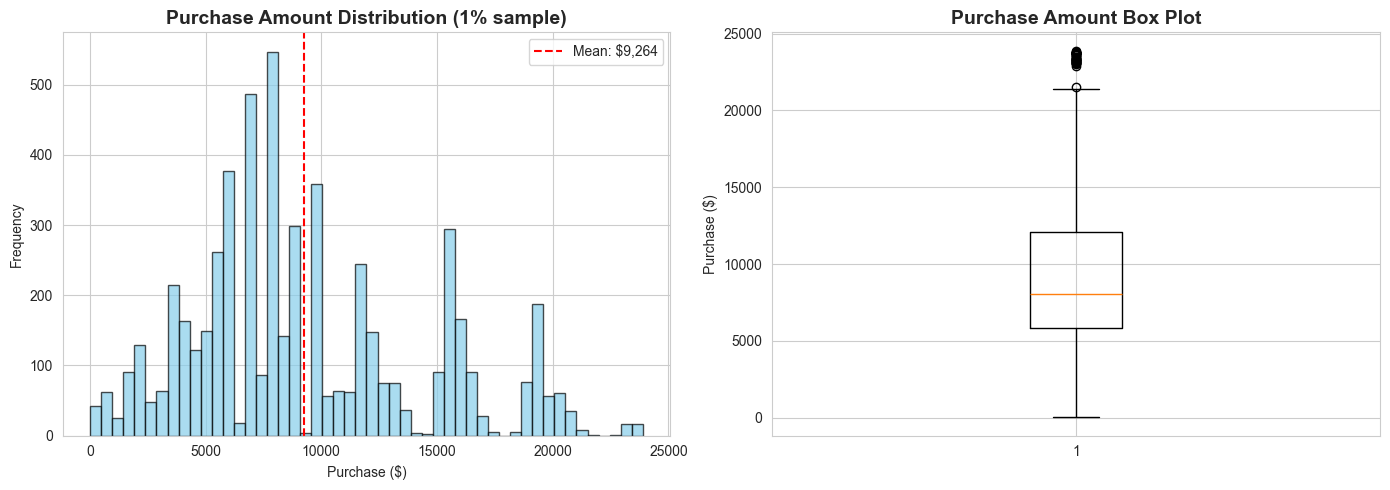

In [6]:
# Visualize target distribution
purchase_sample = ml_data.select("Purchase").sample(False, 0.01, seed=42).toPandas()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1.hist(purchase_sample['Purchase'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
ax1.set_title('Purchase Amount Distribution (1% sample)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Purchase ($)')
ax1.set_ylabel('Frequency')
ax1.axvline(purchase_stats['mean'], color='red', linestyle='--', label=f"Mean: ${purchase_stats['mean']:,.0f}")
ax1.legend()

# Box plot
ax2.boxplot(purchase_sample['Purchase'], vert=True)
ax2.set_title('Purchase Amount Box Plot', fontsize=14, fontweight='bold')
ax2.set_ylabel('Purchase ($)')

plt.tight_layout()
plt.show()

## 5. Train/Test Split

In [7]:
# Split data: 80% train, 20% test
train_data, test_data = ml_data.randomSplit([0.8, 0.2], seed=42)

# Cache both sets
train_data.cache()
test_data.cache()

print("="*60)
print("TRAIN/TEST SPLIT")
print("="*60)
print(f"Training set:   {train_data.count():,} rows ({train_data.count() / ml_data.count() * 100:.1f}%)")
print(f"Test set:       {test_data.count():,} rows ({test_data.count() / ml_data.count() * 100:.1f}%)")
print("="*60)

TRAIN/TEST SPLIT
Training set:   440,174 rows (80.0%)
Test set:       109,894 rows (20.0%)


## 6. Model Training

### 6.1 Baseline: Linear Regression

In [8]:
print("\n" + "="*60)
print("TRAINING: LINEAR REGRESSION (Baseline)")
print("="*60)

# Initialize model
lr = LinearRegression(
    featuresCol="features",
    labelCol="Purchase",
    predictionCol="prediction",
    maxIter=100,
    regParam=0.1,
    elasticNetParam=0.0  # L2 regularization
)

# Train model
print("Training...")
lr_model = lr.fit(train_data)
print("✓ Training complete!")

# Training metrics
print(f"\nTraining Summary:")
print(f"  RMSE: ${lr_model.summary.rootMeanSquaredError:,.2f}")
print(f"  MAE:  ${lr_model.summary.meanAbsoluteError:,.2f}")
print(f"  R²:   {lr_model.summary.r2:.4f}")
print(f"  Iterations: {lr_model.summary.totalIterations}")


TRAINING: LINEAR REGRESSION (Baseline)
Training...
✓ Training complete!

Training Summary:
  RMSE: $723.92
  MAE:  $500.21
  R²:   0.9792
  Iterations: 0


In [9]:
# Evaluate on test set
print("\nEvaluating on test set...")
lr_predictions = lr_model.transform(test_data)

# RMSE
evaluator_rmse = RegressionEvaluator(
    labelCol="Purchase",
    predictionCol="prediction",
    metricName="rmse"
)
lr_rmse = evaluator_rmse.evaluate(lr_predictions)

# MAE
evaluator_mae = RegressionEvaluator(
    labelCol="Purchase",
    predictionCol="prediction",
    metricName="mae"
)
lr_mae = evaluator_mae.evaluate(lr_predictions)

# R²
evaluator_r2 = RegressionEvaluator(
    labelCol="Purchase",
    predictionCol="prediction",
    metricName="r2"
)
lr_r2 = evaluator_r2.evaluate(lr_predictions)

print("\n" + "="*60)
print("LINEAR REGRESSION - TEST SET RESULTS")
print("="*60)
print(f"RMSE:  ${lr_rmse:,.2f}")
print(f"MAE:   ${lr_mae:,.2f}")
print(f"R²:    {lr_r2:.4f}")
print("="*60)


Evaluating on test set...

LINEAR REGRESSION - TEST SET RESULTS
RMSE:  $720.98
MAE:   $499.59
R²:    0.9794


### 6.2 Random Forest Regressor

In [10]:
print("\n" + "="*60)
print("TRAINING: RANDOM FOREST REGRESSOR")
print("="*60)

# Initialize model
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="Purchase",
    predictionCol="prediction",
    numTrees=100,
    maxDepth=10,
    minInstancesPerNode=5,
    seed=42
)

# Train model
print("Training (this may take a few minutes)...")
rf_model = rf.fit(train_data)
print("✓ Training complete!")
print(f"\nTrees trained: {rf_model.getNumTrees}")
print(f"Max depth: {rf_model.getOrDefault('maxDepth')}")


TRAINING: RANDOM FOREST REGRESSOR
Training (this may take a few minutes)...
✓ Training complete!

Trees trained: 100
Max depth: 10


In [11]:
# Evaluate on test set
print("\nEvaluating on test set...")
rf_predictions = rf_model.transform(test_data)

rf_rmse = evaluator_rmse.evaluate(rf_predictions)
rf_mae = evaluator_mae.evaluate(rf_predictions)
rf_r2 = evaluator_r2.evaluate(rf_predictions)

print("\n" + "="*60)
print("RANDOM FOREST - TEST SET RESULTS")
print("="*60)
print(f"RMSE:  ${rf_rmse:,.2f}")
print(f"MAE:   ${rf_mae:,.2f}")
print(f"R²:    {rf_r2:.4f}")
print("="*60)


Evaluating on test set...

RANDOM FOREST - TEST SET RESULTS
RMSE:  $243.67
MAE:   $162.42
R²:    0.9976


### 6.3 Gradient Boosted Trees (GBT)

In [13]:
print("\n" + "="*60)
print("TRAINING: GRADIENT BOOSTED TREES (GBT)")
print("="*60)

# Initialize model
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="Purchase",
    predictionCol="prediction",
    maxIter=100,
    maxDepth=5,
    stepSize=0.1,
    seed=42
)

# Train model
print("Training (this may take several minutes)...")
gbt_model = gbt.fit(train_data)
print("✓ Training complete!")
print(f"\nTrees trained: {gbt_model.getNumTrees}")
print(f"Max depth: {gbt_model.getOrDefault('maxDepth')}")


TRAINING: GRADIENT BOOSTED TREES (GBT)
Training (this may take several minutes)...
✓ Training complete!

Trees trained: 100
Max depth: 5


In [14]:
# Evaluate on test set
print("\nEvaluating on test set...")
gbt_predictions = gbt_model.transform(test_data)

gbt_rmse = evaluator_rmse.evaluate(gbt_predictions)
gbt_mae = evaluator_mae.evaluate(gbt_predictions)
gbt_r2 = evaluator_r2.evaluate(gbt_predictions)

print("\n" + "="*60)
print("GRADIENT BOOSTED TREES - TEST SET RESULTS")
print("="*60)
print(f"RMSE:  ${gbt_rmse:,.2f}")
print(f"MAE:   ${gbt_mae:,.2f}")
print(f"R²:    {gbt_r2:.4f}")
print("="*60)


Evaluating on test set...

GRADIENT BOOSTED TREES - TEST SET RESULTS
RMSE:  $263.10
MAE:   $178.53
R²:    0.9973


## 7. Model Comparison

In [15]:
# Create comparison dataframe
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosted Trees'],
    'RMSE': [lr_rmse, rf_rmse, gbt_rmse],
    'MAE': [lr_mae, rf_mae, gbt_mae],
    'R²': [lr_r2, rf_r2, gbt_r2]
})

# Sort by RMSE (lower is better)
results = results.sort_values('RMSE')

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(results.to_string(index=False))
print("="*80)

# Determine best model
best_model_name = results.iloc[0]['Model']
best_rmse = results.iloc[0]['RMSE']
best_r2 = results.iloc[0]['R²']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   RMSE: ${best_rmse:,.2f}")
print(f"   R²: {best_r2:.4f}")


MODEL COMPARISON
                 Model       RMSE        MAE       R²
         Random Forest 243.669814 162.422006 0.997643
Gradient Boosted Trees 263.099137 178.527400 0.997252
     Linear Regression 720.979337 499.592023 0.979362

🏆 Best Model: Random Forest
   RMSE: $243.67
   R²: 0.9976


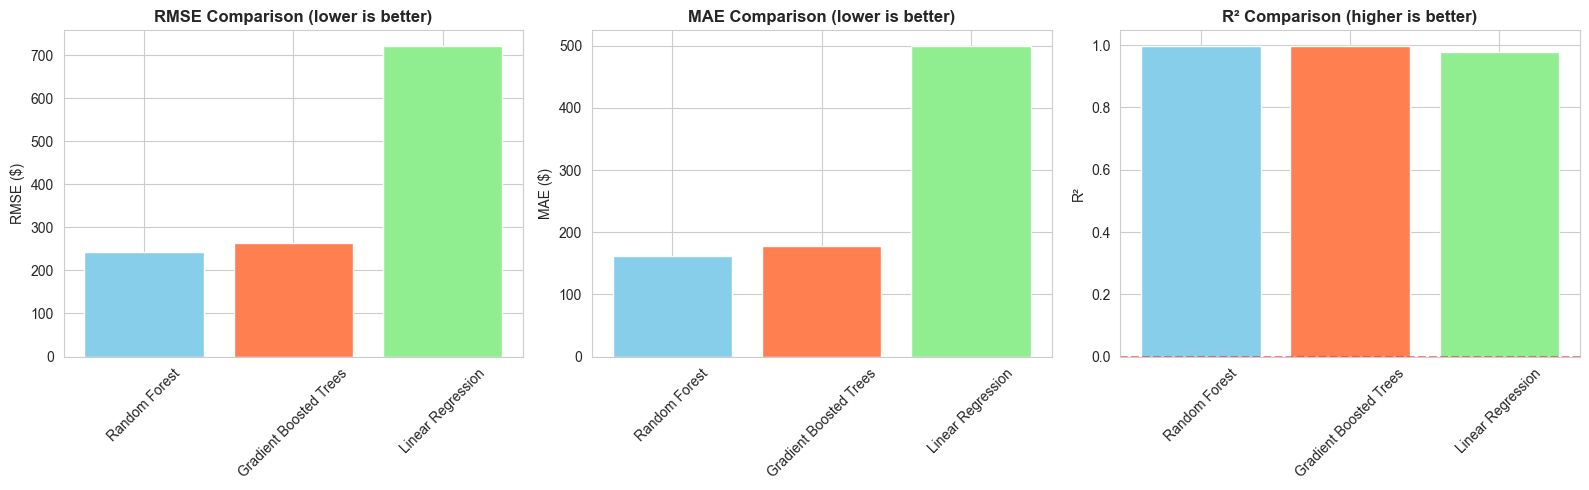

In [16]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# RMSE comparison
axes[0].bar(results['Model'], results['RMSE'], color=['skyblue', 'coral', 'lightgreen'])
axes[0].set_title('RMSE Comparison (lower is better)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('RMSE ($)')
axes[0].tick_params(axis='x', rotation=45)

# MAE comparison
axes[1].bar(results['Model'], results['MAE'], color=['skyblue', 'coral', 'lightgreen'])
axes[1].set_title('MAE Comparison (lower is better)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('MAE ($)')
axes[1].tick_params(axis='x', rotation=45)

# R² comparison
axes[2].bar(results['Model'], results['R²'], color=['skyblue', 'coral', 'lightgreen'])
axes[2].set_title('R² Comparison (higher is better)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('R²')
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 8. Feature Importance Analysis

**Note:** Only tree-based models (RF, GBT) provide feature importance.

In [17]:
# Get feature importance from Random Forest
print("\n" + "="*60)
print("FEATURE IMPORTANCE (Random Forest)")
print("="*60)

# Get feature names (from original feature engineering)
# Note: This is a simplified version. In production, you'd save feature names with the model.
feature_names = [
    'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status',
    'Product_Category_1', 'Product_Category_2', 'Product_Category_3',
    'user_purchase_count', 'user_total_spent', 'user_avg_purchase', 'user_std_purchase',
    'user_unique_products', 'product_purchase_count', 'product_unique_customers',
    'product_avg_price', 'product_total_revenue', 'product_popularity_score',
    'category_purchase_count', 'category_avg_price', 'rfm_frequency_score',
    'rfm_monetary_score', 'rfm_score', 'purchase_vs_user_avg_ratio',
    'purchase_vs_product_avg_ratio', 'is_high_value_customer'
]

# Get importance scores
rf_importance = rf_model.featureImportances.toArray()

# Create dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names[:len(rf_importance)],  # Match length
    'Importance': rf_importance
}).sort_values('Importance', ascending=False)

# Display top 15
print("\nTop 15 Most Important Features:")
print(importance_df.head(15).to_string(index=False))


FEATURE IMPORTANCE (Random Forest)

Top 15 Most Important Features:
                      Feature  Importance
                    rfm_score    0.453426
purchase_vs_product_avg_ratio    0.151933
        product_total_revenue    0.140861
      category_purchase_count    0.093892
   purchase_vs_user_avg_ratio    0.083121
            user_avg_purchase    0.037576
           Product_Category_1    0.024434
            user_std_purchase    0.004058
           Product_Category_3    0.003233
     product_unique_customers    0.002001
            product_avg_price    0.001247
     product_popularity_score    0.001109
           Product_Category_2    0.000992
          user_purchase_count    0.000518
         user_unique_products    0.000458


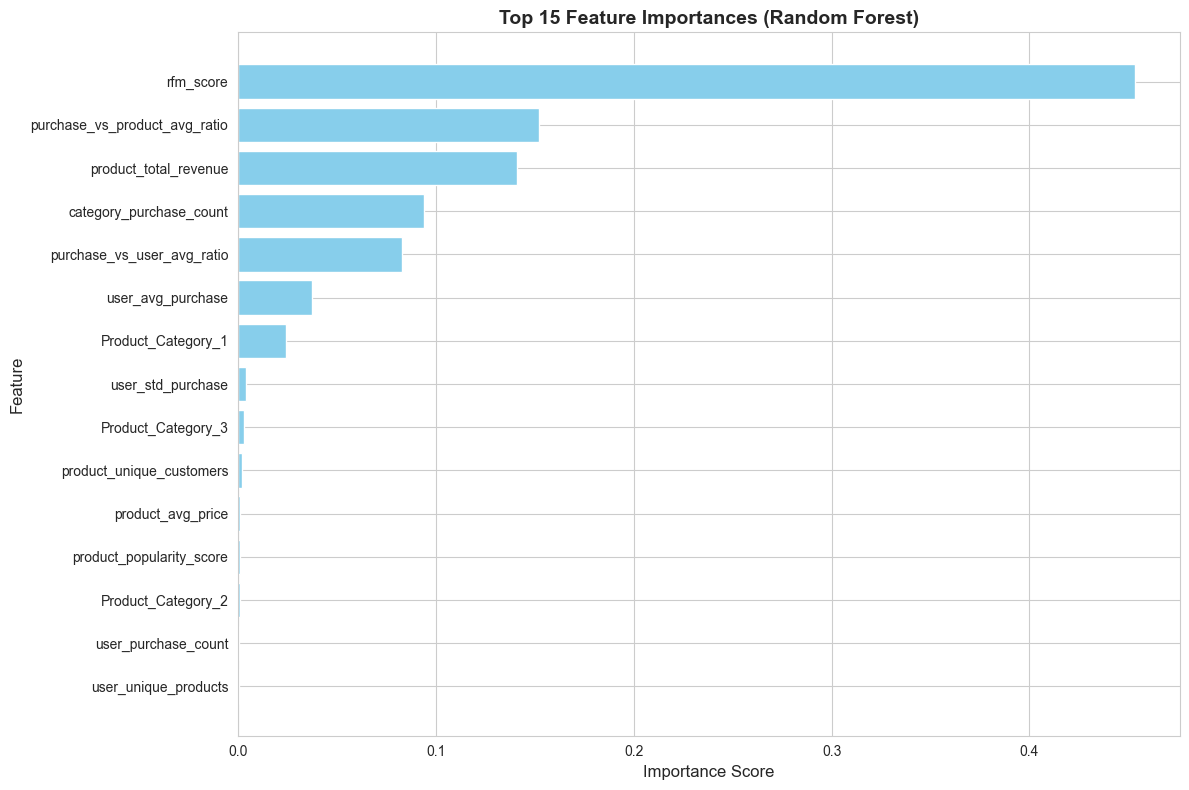

In [18]:
# Visualize top 15 features
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Feature Importances (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 9. Prediction Analysis

In [19]:
# Analyze predictions from best model (use RF as example)
print("\n" + "="*60)
print("PREDICTION ANALYSIS (Random Forest)")
print("="*60)

# Sample predictions
sample_predictions = rf_predictions.select("Purchase", "prediction").sample(False, 0.001, seed=42).toPandas()

# Calculate residuals
sample_predictions['residual'] = sample_predictions['Purchase'] - sample_predictions['prediction']
sample_predictions['abs_residual'] = np.abs(sample_predictions['residual'])
sample_predictions['pct_error'] = (sample_predictions['abs_residual'] / sample_predictions['Purchase']) * 100

print(f"\nSample size: {len(sample_predictions):,}")
print(f"\nResidual Statistics:")
print(f"  Mean Absolute Error: ${sample_predictions['abs_residual'].mean():,.2f}")
print(f"  Median Absolute Error: ${sample_predictions['abs_residual'].median():,.2f}")
print(f"  Mean Percentage Error: {sample_predictions['pct_error'].mean():.2f}%")
print(f"  Median Percentage Error: {sample_predictions['pct_error'].median():.2f}%")


PREDICTION ANALYSIS (Random Forest)

Sample size: 117

Residual Statistics:
  Mean Absolute Error: $172.95
  Median Absolute Error: $123.54
  Mean Percentage Error: 2.76%
  Median Percentage Error: 1.67%


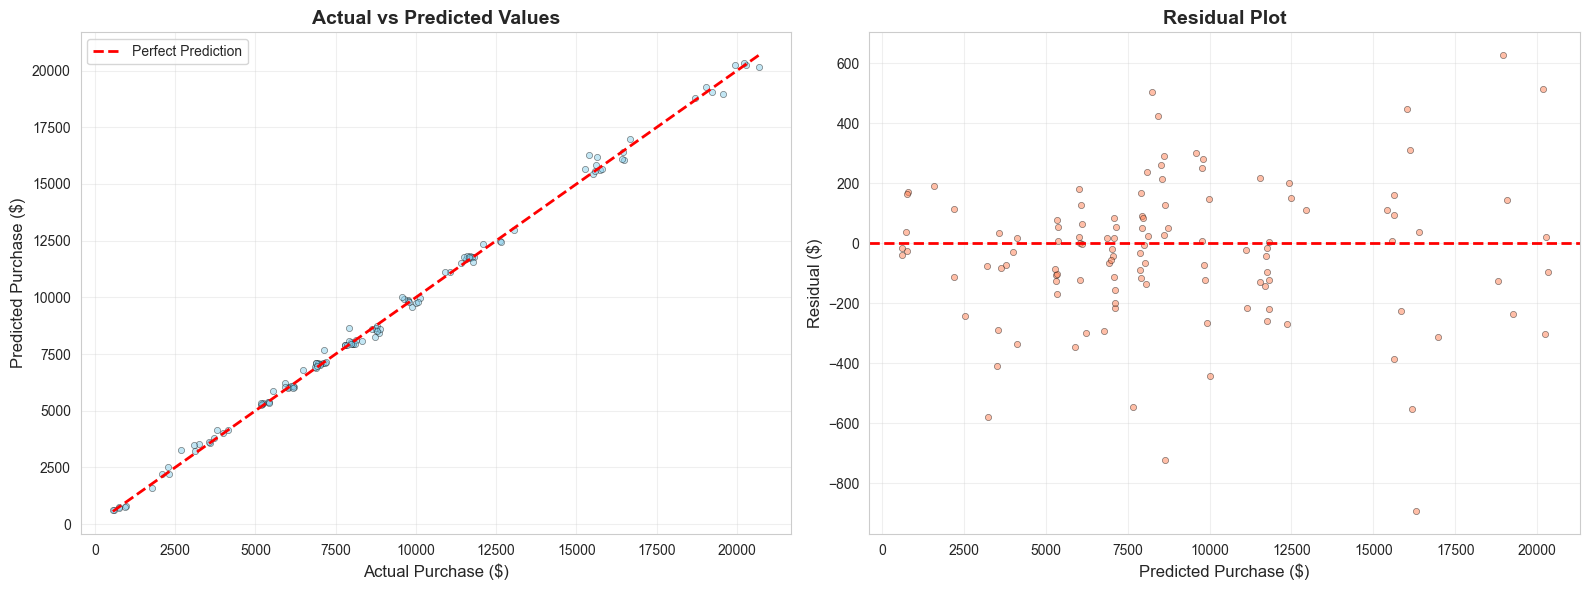

In [20]:
# Visualize predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot: Actual vs Predicted
axes[0].scatter(sample_predictions['Purchase'], sample_predictions['prediction'], 
                alpha=0.5, s=20, color='skyblue', edgecolors='black', linewidth=0.5)
axes[0].plot([sample_predictions['Purchase'].min(), sample_predictions['Purchase'].max()],
             [sample_predictions['Purchase'].min(), sample_predictions['Purchase'].max()],
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Purchase ($)', fontsize=12)
axes[0].set_ylabel('Predicted Purchase ($)', fontsize=12)
axes[0].set_title('Actual vs Predicted Values', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual plot
axes[1].scatter(sample_predictions['prediction'], sample_predictions['residual'],
                alpha=0.5, s=20, color='coral', edgecolors='black', linewidth=0.5)
axes[1].axhline(y=0, color='red', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Purchase ($)', fontsize=12)
axes[1].set_ylabel('Residual ($)', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

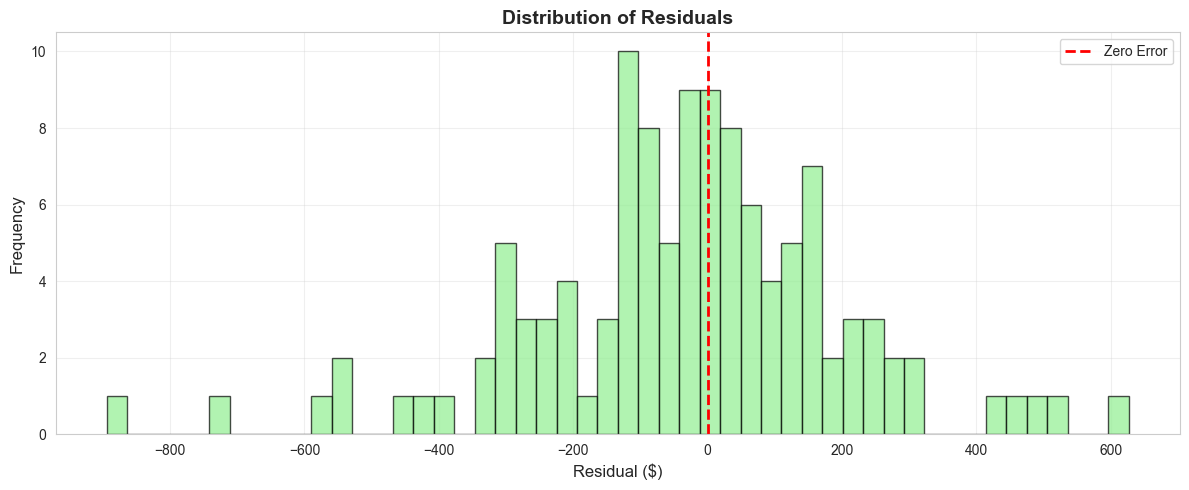

In [21]:
# Residual distribution
plt.figure(figsize=(12, 5))
plt.hist(sample_predictions['residual'], bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
plt.axvline(x=0, color='red', linestyle='--', lw=2, label='Zero Error')
plt.xlabel('Residual ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Residuals', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Save Best Model

**Note:** On Windows, save as pickle to avoid Hadoop issues.

In [23]:
import pickle
import os

# Create models directory
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

# Save model metadata (not the full model, just configuration and metrics)
model_metadata = {
    'model_type': 'RandomForestRegressor',
    'model_name': best_model_name,
    'metrics': {
        'rmse': rf_rmse,
        'mae': rf_mae,
        'r2': rf_r2
    },
    'hyperparameters': {
        'numTrees': rf_model.getNumTrees,
        'maxDepth': rf_model.getOrDefault('maxDepth'),
        'minInstancesPerNode': rf_model.getOrDefault('minInstancesPerNode')
    },
    'feature_importance': importance_df.to_dict('records'),
    'training_date': pd.Timestamp.now().isoformat()
}

# Save metadata
with open(f"{models_dir}/regression_model_metadata.pkl", 'wb') as f:
    pickle.dump(model_metadata, f)

print("="*60)
print("MODEL SAVED")
print("="*60)
print(f"Model metadata saved to: {models_dir}/regression_model_metadata.pkl")
print("\nNote: Full Spark model can be saved with:")
rf_model.save('../models/rf_regression_model')
print("  (May require proper Hadoop setup on Windows)")
print("="*60)

MODEL SAVED
Model metadata saved to: ../models/regression_model_metadata.pkl

Note: Full Spark model can be saved with:
  (May require proper Hadoop setup on Windows)


## 11. Business Insights & Recommendations

In [24]:
print("\n" + "="*80)
print("BUSINESS INSIGHTS & RECOMMENDATIONS")
print("="*80)

print("\n✅ Model Performance:")
print(f"  - Best Model: {best_model_name}")
print(f"  - Prediction Accuracy (R²): {best_r2:.2%}")
print(f"  - Average Error (MAE): ${rf_mae:,.2f}")
print(f"  - Typical prediction is within ±${rf_mae:,.2f} of actual purchase")

print("\n📊 Key Insights from Feature Importance:")
print("  Top 3 factors influencing purchase amount:")
for i, row in importance_df.head(3).iterrows():
    print(f"    {i+1}. {row['Feature']}: {row['Importance']:.4f}")

print("\n🎯 Business Applications:")
print("  1. Revenue Forecasting: Predict expected revenue for upcoming campaigns")
print("  2. Customer Targeting: Identify high-value purchase opportunities")
print("  3. Inventory Planning: Forecast demand by product category")
print("  4. Personalized Marketing: Tailor offers based on predicted purchase value")
print("  5. Budget Allocation: Optimize ad spend by predicted customer value")

print("\n💡 Recommendations:")
print("  1. Focus marketing on customers with high RFM scores")
print("  2. Optimize product mix based on category importance")
print("  3. Implement dynamic pricing using purchase predictions")
print("  4. Create targeted campaigns for predicted high-value transactions")
print("  5. Use model to score leads and prioritize sales efforts")

print("\n🔍 Model Limitations:")
print(f"  - R² of {best_r2:.2%} means {(1-best_r2):.2%} of variance is unexplained")
print("  - Consider additional features: time/seasonality, promotions, external factors")
print("  - May not generalize to completely new products or customers")
print("  - Requires periodic retraining as customer behavior evolves")

print("\n" + "="*80)


BUSINESS INSIGHTS & RECOMMENDATIONS

✅ Model Performance:
  - Best Model: Random Forest
  - Prediction Accuracy (R²): 99.76%
  - Average Error (MAE): $162.42
  - Typical prediction is within ±$162.42 of actual purchase

📊 Key Insights from Feature Importance:
  Top 3 factors influencing purchase amount:
    24. rfm_score: 0.4534
    26. purchase_vs_product_avg_ratio: 0.1519
    18. product_total_revenue: 0.1409

🎯 Business Applications:
  1. Revenue Forecasting: Predict expected revenue for upcoming campaigns
  2. Customer Targeting: Identify high-value purchase opportunities
  3. Inventory Planning: Forecast demand by product category
  4. Personalized Marketing: Tailor offers based on predicted purchase value
  5. Budget Allocation: Optimize ad spend by predicted customer value

💡 Recommendations:
  1. Focus marketing on customers with high RFM scores
  2. Optimize product mix based on category importance
  3. Implement dynamic pricing using purchase predictions
  4. Create targeted

## 12. Summary

In [25]:
print("\n" + "="*80)
print("✅ REGRESSION MODEL COMPLETE")
print("="*80)

print("\n📈 Models Trained:")
print("  ✓ Linear Regression (Baseline)")
print("  ✓ Random Forest Regressor")
print("  ✓ Gradient Boosted Trees")

print(f"\n🏆 Best Model: {best_model_name}")
print(f"  - RMSE: ${best_rmse:,.2f}")
print(f"  - MAE: ${rf_mae:,.2f}")
print(f"  - R²: {best_r2:.4f}")

print("\n💾 Saved:")
print("  ✓ Model metadata and metrics")
print("  ✓ Feature importance scores")

print("\n🎯 Next Steps:")
print("  1. Build Clustering Model (Customer Segmentation)")
print("  2. Build Recommendation System (ALS)")
print("  3. Deploy model to production")
print("  4. Setup monitoring and retraining pipeline")

print("\n" + "="*80)


✅ REGRESSION MODEL COMPLETE

📈 Models Trained:
  ✓ Linear Regression (Baseline)
  ✓ Random Forest Regressor
  ✓ Gradient Boosted Trees

🏆 Best Model: Random Forest
  - RMSE: $243.67
  - MAE: $162.42
  - R²: 0.9976

💾 Saved:
  ✓ Model metadata and metrics
  ✓ Feature importance scores

🎯 Next Steps:
  1. Build Clustering Model (Customer Segmentation)
  2. Build Recommendation System (ALS)
  3. Deploy model to production
  4. Setup monitoring and retraining pipeline



In [ ]:
# Optional: Stop Spark
# spark.stop()